In [98]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, KFold

import mylib as my

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

Part 1: Data Pre-processing
Prepare data for classification models.

In [140]:
# Read file and print header
park_data = pd.read_csv('Park_Acoustic.csv')  
print(park_data.head(5))

        ID  Recording  Status  Gender  Jitter_rel  Jitter_abs  Jitter_RAP  \
0  CONT-01          1       0       1     0.25546    0.000015    0.001467   
1  CONT-01          2       0       1     0.36964    0.000022    0.001932   
2  CONT-01          3       0       1     0.23514    0.000013    0.001353   
3  CONT-02          1       0       0     0.29320    0.000017    0.001105   
4  CONT-02          2       0       0     0.23075    0.000015    0.001073   

   Jitter_PPQ  Shim_loc  Shim_dB  ...    Delta3    Delta4    Delta5    Delta6  \
0    0.001673  0.030256  0.26313  ...  1.407701  1.417218  1.380352  1.420670   
1    0.002245  0.023146  0.20217  ...  1.331232  1.227338  1.213377  1.352739   
2    0.001546  0.019338  0.16710  ...  1.412304  1.324674  1.276088  1.429634   
3    0.001444  0.024716  0.20892  ...  1.501200  1.534170  1.323993  1.496442   
4    0.001404  0.013119  0.11607  ...  1.508468  1.334511  1.610694  1.685021   

     Delta7    Delta8    Delta9   Delta10   Delta1

In [141]:
# Create dataframes with data grouped by individual patient
# Mean values only
park_data_grp_1 = park_data.groupby(['ID']).mean()

# Mean values with standard deviations as additional variables
park_data_grp_2 = pd.concat([park_data.groupby('ID').mean(), park_data.groupby('ID').std()], axis=1)

In [142]:
# Pop status column
status_col = park_data_grp_1.pop('Status')
park_data_grp_2.pop('Status')
print(status_col)

ID
CONT-01    0.0
CONT-02    0.0
CONT-03    0.0
CONT-04    0.0
CONT-05    0.0
          ... 
PARK-36    1.0
PARK-37    1.0
PARK-38    1.0
PARK-39    1.0
PARK-40    1.0
Name: Status, Length: 80, dtype: float64


In [143]:
# Add status column to end of each dataframe, check position
park_data_grp_1.insert(park_data_grp_1.shape[1], "Status", status_col.values, allow_duplicates=True)
print(park_data_grp_1.head(5))

park_data_grp_2.insert(park_data_grp_2.shape[1], "Status", status_col.values, allow_duplicates=True)
print(park_data_grp_2.head(5))

         Recording  Gender  Jitter_rel  Jitter_abs  Jitter_RAP  Jitter_PPQ  \
ID                                                                           
CONT-01        2.0     1.0    0.286747    0.000016    0.001584    0.001821   
CONT-02        2.0     0.0    0.229613    0.000014    0.000999    0.001347   
CONT-03        2.0     1.0    0.228300    0.000015    0.001361    0.001538   
CONT-04        2.0     1.0    1.138800    0.000089    0.006879    0.006169   
CONT-05        2.0     0.0    0.601363    0.000078    0.002963    0.003630   

         Shim_loc   Shim_dB  Shim_APQ3  Shim_APQ5  ...    Delta4    Delta5  \
ID                                                 ...                       
CONT-01  0.024247  0.210800   0.013841   0.015480  ...  1.323076  1.289939   
CONT-02  0.016167  0.139909   0.008835   0.010288  ...  1.514699  1.436049   
CONT-03  0.018355  0.160563   0.009814   0.012021  ...  1.492976  1.477870   
CONT-04  0.025849  0.227540   0.014722   0.014495  ...  1.44719

In [144]:
# Drop recording column
park_data_grp_1.drop(['Recording'], axis=1, inplace=True)
park_data_grp_2.drop(['Recording'], axis=1, inplace=True)

print(park_data_grp_2.head(5))

         Gender  Jitter_rel  Jitter_abs  Jitter_RAP  Jitter_PPQ  Shim_loc  \
ID                                                                          
CONT-01     1.0    0.286747    0.000016    0.001584    0.001821  0.024247   
CONT-02     0.0    0.229613    0.000014    0.000999    0.001347  0.016167   
CONT-03     1.0    0.228300    0.000015    0.001361    0.001538  0.018355   
CONT-04     1.0    1.138800    0.000089    0.006879    0.006169  0.025849   
CONT-05     0.0    0.601363    0.000078    0.002963    0.003630  0.035647   

          Shim_dB  Shim_APQ3  Shim_APQ5  Shi_APQ11  ...    Delta4    Delta5  \
ID                                                  ...                       
CONT-01  0.210800   0.013841   0.015480   0.017249  ...  0.094950  0.084345   
CONT-02  0.139909   0.008835   0.010288   0.012707  ...  0.171285  0.153256   
CONT-03  0.160563   0.009814   0.012021   0.014385  ...  0.117069  0.134662   
CONT-04  0.227540   0.014722   0.014495   0.019822  ...  0.113368

In [58]:
# Function to standardize data
def standardize_arr(arr):
    scaler = StandardScaler()
    temp1 = arr[:,0:1]
    temp2 = scaler.fit_transform(arr[:,1:])
    std_arr = np.concatenate((temp1, temp2), axis=1)
    return std_arr

In [145]:
# Use mylib.from_dataframe to produce arrays
X, y, features, targets = my.from_dataframe(park_data_grp_1, ntargets=1)

In [146]:
# Standardize data
X = standardize_arr(X)

In [147]:
# Split data 80/20
X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size=.20, random_state=17)

Part 2: Model Training

In [88]:
# Create parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
			'kernel': ['linear']} 

# Initialize GridSearchCV object
grid_SVC = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 1) 

# Find and print best values of C and gamma
grid_SVC.fit(X_train, y_train)
print(grid_SVC.best_params_) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'C': 0.01, 'gamma': 1, 'kernel': 'linear'}


In [89]:
# Fit optimized SVC model
park_svc = svm.SVC(kernel='linear', C=0.01, gamma=1) # Linear Kernel
park_svc.fit(X_train, y_train)

SVC(C=0.01, gamma=1, kernel='linear')

SVC Accuracy Score: 0.9375


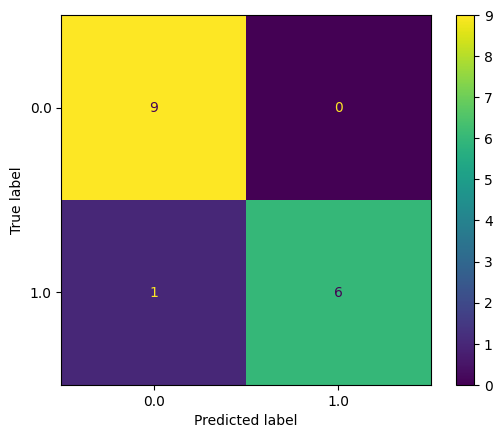

In [90]:
# Generate predictions
svc_preds = park_svc.predict(X_test)
print(f'SVC Accuracy Score: {accuracy_score(y_test, svc_preds)}')

# Plot confusion matrix
svc_cm = confusion_matrix(y_test, svc_preds, labels=park_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=svc_cm, display_labels=park_svc.classes_)
disp.plot()
plt.show()

In [91]:
# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = cross_val_score(park_svc, X, y, cv=kf)
for i, result in enumerate(cross_val_results, 1):
    print(f"  Fold {i}: {result * 100:.2f}%")
print(f'Mean Accuracy: {cross_val_results.mean()* 100:.2f}%')

  Fold 1: 81.25%
  Fold 2: 81.25%
  Fold 3: 87.50%
  Fold 4: 68.75%
  Fold 5: 87.50%
Mean Accuracy: 81.25%


In [78]:
# Create parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [2, 4]
}

grid_RF = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_RF.fit(X_train, y_train)

print("Best Parameters:", grid_RF.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 100}


In [79]:
# Fit RF model
park_rf = RandomForestClassifier(max_depth=10, random_state=0, min_samples_split=7, min_samples_leaf=4, n_estimators=100, bootstrap=True)
park_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=7,
                       random_state=0)

Random Forest Accuracy Score: 0.9375


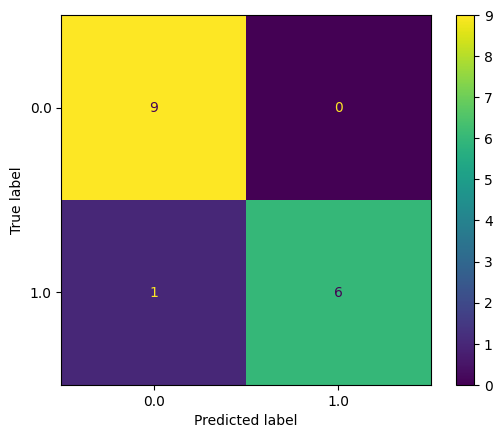

In [80]:
# Generate predictions
rf_preds = park_rf.predict(X_test)
print(f'Random Forest Accuracy Score: {accuracy_score(y_test, rf_preds)}')

# Plot confusion matrix
rf_cm = confusion_matrix(y_test, rf_preds, labels=park_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=park_rf.classes_)
disp.plot()
plt.show()

In [81]:
# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = cross_val_score(park_rf, X, y, cv=kf)
for i, result in enumerate(cross_val_results, 1):
    print(f"  Fold {i}: {result * 100:.2f}%")
print(f'Mean Accuracy: {cross_val_results.mean()* 100:.2f}%')


  Fold 1: 75.00%
  Fold 2: 75.00%
  Fold 3: 93.75%
  Fold 4: 68.75%
  Fold 5: 87.50%
Mean Accuracy: 80.00%
